# A Generative Model for Pokemon Unown

![](https://github.com/lopeLH/unown-mnist/blob/main/doc/examples.png?raw=true)


We'll fit a Bernoulli Naïve Bayes model to the pokemon dataset, and use this model for making predictions and generating new images from the same distribution. pokemon is a dataset of 28x28 images of items of pokemon symbols.

We represent each image by a vector $x^{(i)} \in \{0,1\}^{D}$, where 0 and 1 represent white and black pixels respectively, and $D=784$. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a K=28-dimensional one-hot vector.

The Bernoulli Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{D}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$, i.e. $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$.

In [ ]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def unown_mnist():
    base_url = 'https://github.com/lopeLH/unown-mnist/raw/refs/heads/main/'
    X_test_url = 'X_test.npy'
    X_train_url = 'X_train.npy'
    y_train_url = 'Y_train.npy'
    y_test_url = 'Y_test.npy'

    for filename in [X_train_url,X_test_url,
                     y_train_url,y_test_url]:
        download(base_url + filename, filename)

    X_train =  np.load('./data/X_train.npy')
    X_test =  np.load('./data/X_test.npy')
    Y_train =  np.load('./data/Y_train.npy')
    Y_test =  np.load('./data/Y_test.npy')

    return X_train,Y_train, X_test, Y_test

def load_unown_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))

    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = unown_mnist()
    num_unique_labels = len(np.unique(train_labels))
    train_images = (partial_flatten(train_images) / 255.0).astype(float)
    test_images = (partial_flatten(test_images) / 255.0).astype(float)
    train_images_binarized = (train_images > 0.5).astype(float)
    test_images_binarized = (test_images > 0.5).astype(float)
    train_labels = one_hot(train_labels, num_unique_labels)
    test_labels = one_hot(test_labels, num_unique_labels)
    N_data = train_images.shape[0]

    return N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels

In [ ]:
N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels = load_unown_mnist()

In [ ]:
X_train,Y_train, X_test, Y_test = unown_mnist()
len(train_labels[0])

28

We have parametrize the model as follow: \
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{D}p(x_j|c,\theta),$$ such that $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$. While $\pi$ is a vector of length 28, consisting of prior probability of each of 28 classes. While $\theta_{jc}$ represents the probability of the $j$th pixel in class c showing **black**. \
 \
Consider likelihood function as follow, say totally $N$ observations: \
$l(\pi,\theta|x^{(i)},c^{(i)}) = \sum_{i=1}^{N}log(p(x^{(i)},c^{(i)}|\pi,\theta))$ \
$= \sum_{i=1}^{N}log(p(c^{(i)}|\pi)\prod_{j=1}^{D}p(x_j^{(i)}|c^{(i)},\theta))$ \
$= \sum_{i=1}^{N}log(p(c^{(i)}|\pi))+\sum_{i=1}^{N}\sum_{j=1}^{D}log(p(x_j^{(i)}|c^{(i)},\theta))$ \
$= \sum_{i=1}^{N}log(\pi_{c^{(i)}})+\sum_{i=1}^{N}\sum_{j=1}^{D}log(\theta_{jc^{(i)}}^{x_j^{(i)}}(1-\theta_{jc^{(i)}})^{1-x_j^{(i)}})$ \
$= \sum_{i=1}^{N}log(\pi_{c^{(i)}})+\sum_{i=1}^{N}\sum_{j=1}^{D}(x_j^{(i)}log(\theta_{jc^{(i)}})+(1-x_j^{(i)})log(1-\theta_{jc^{(i)}}))$ \
$= l_1(\pi)+ \sum_{j=1}^{D}l_2(\theta_j)$, with $D=784$.\
 \
*  Consider $l_1(\pi)$ to find MLE of $\pi_c$ for each class $c$: \
Note that $\pi_{c^{(i)}}={{\pi_c}^{1\{c^{(i)}=c\}}}{{(1-\pi_c)}^{1\{c^{(i)} \neq c\}}}$. \
Then we will have $l_1(\pi)= ∑_{i=1}^{N}1\{c^{(i)}=c\}log(\pi_c)+ \sum_{i=1}^{N}1\{c^{(i)} \neq c\}log(1-\pi_c)$. \
$\frac{∂{l_1}}{∂{\pi_c}}= ∑_{i=1}^{N}\frac{1\{c^{(i)}=c\}}{\pi_c}-∑_{i=1}^{N}\frac{1\{c^{(i)} \neq c\}}{1-\pi_c}=0$. \
Using the property that $1\{c^{(i)}=c\}+1\{c^{(i)} \neq c\}=1$, we can solve to get $\hat{\pi_c}=\frac{ ∑_{i=1}^{N}1\{c^{(i)}=c\}}{N}= \frac{number \ of \ c^{(i)} \ belong \ to \ class \ c}{total \ number \ of \ c^{(i)}}$
*  Consider $l_2(\theta_j)$ to find MLE of $\theta_{jc}$: \
$l_2(θ_j)= \sum_{i=1}^{N}\Big(x_j^{(i)}log(\theta_{jc^{(i)}})+(1-x_j^{(i)})log(1-\theta_{jc^{(i)}})\Big)$ \
Take derivative wrt $ \theta_{jc}$:$\frac{\partial{l_2}}{\partial{\theta_{jc}}}= \sum_{i=1}^{N}\Big( \frac{x_j^{(i)}1\{ c^{(i)}=c\}}{\theta_{jc}}- \frac{(1-x_j^{(i)})1\{ c^{(i)}=c\}}{1- \theta_{jc}} \Big)=0$. \
Simplify to get $ \sum_{i=1}^{N}x_j^{(i)}1 \{c^{(i)}=c \}= \sum_{i=1}^{N} \theta_{jc}1\{ c^{(i)}=c\}$. \
Solve to get: $\hat\theta_{jc} = \frac{ \sum_{i=1}^{N}x_j^{(i)}1 \{c^{(i)}=c \}}{ \sum_{i=1}^{N}1\{ c^{(i)}=c\}}$, which is the probability of the $j$th pixel belonging to a class $c$.





In [ ]:
def  train_map_estimator(train_images, train_labels, alpha):

    pi_est = np.mean(train_labels, axis=0)
    j = train_images.shape[1]
    numerator = np.transpose(train_images).dot(train_labels) + (alpha - 1)
    denominator = np.tile(np.sum(train_labels, axis=0) + (2 * alpha - 2), (j,1))
    theta_est = numerator / denominator
    return theta_est, pi_est

Bayes Theorem says: $P(c|x, \theta, \pi) = \frac{P(c,x| \theta, \pi)}{P(x|\theta,\pi)}$. \
Since we know $p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{D}p(x_j|c,\theta)=\pi_c \prod_{j=1}^{D}\theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$ for some class $c$, \
then take natural log to get $log\Big(p(c,x|\theta,\pi)\Big)=log(\pi_c)+ \sum_{j=1}^{D}\Big( x_jlog(\theta_{jc})+(1-x_j)log(1-\theta_{jc}) \Big)$ \
Now consider denominator, it's obvious that $p(x|\theta,\pi)=\sum_{c \in [28]}p(x,c|\theta,\pi)$, \
then we have $log\Big(p(c,x|\theta,\pi) \Big)=log\Big(\sum_{c \in [28]}p(x,c|\theta,\pi) \Big)=log\Big(\sum_{c \in [28]}exp\{log(p(x,c|\theta, \pi))\} \Big)$ \
$=log\Big(\sum_{c \in [28]}exp\{log(\pi_c) \sum_{j=1}^{D}\Big( x_jlog(\theta_{jc})+(1-x_j)log(1-\theta_{jc}) \Big)\} \Big)$. \
Therefore the log-likelihood will be $log\Big(p(c|x,\theta,\pi) \Big)=log\Big( p(c,x|\theta,\pi)\Big)-log\Big(\sum_{c \in [28]}p(x,c|\theta,\pi) \Big)$ with the expansion of each logarithm shown above. \

Result shows: \
* Average log-likelihood for MAP with alpha = 2 is -0.253. \
* Training accuracy for MAP with alpha = 2 is 0.989. \
+ Test accuracy for MAP with alpha = 2 is 0.990.




In [ ]:
def log_likelihood(images, theta, pi):

    log_theta = np.log(theta)
    minus_log_theta = np.log(1 - theta)

    # derive log_like, not necessary to normalize here
    log_like = np.dot(images, log_theta) + \
    np.dot(1 - images, minus_log_theta) + np.log(pi)
    return log_like

def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    N = log_like.shape[0]
    c = log_like.shape[1]
    # Create a zero matrix, add 1 to the entry corresponding to the max log_like,
    # update the num_correct for each iteration.
    emp = np.zeros((N, c))
    num_correct = 0
    mle_label = np.argmax(log_like, axis = 1)
    for i in range(N):
      emp[i, mle_label[i]] += 1
      num_correct += (emp[i, mle_label[i]] == labels[i, mle_label[i]])
    accuracy = num_correct / N
    return accuracy


N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels = load_unown_mnist()

theta_est, pi_est = train_map_estimator(train_images_binarized, train_labels, alpha=2.)

loglike_train = log_likelihood(train_images_binarized, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images_binarized, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP with alpha = 2 is {avg_loglike:.3f}")
print(f"Training accuracy for MAP with alpha = 2 is {train_accuracy:.3f}")
print(f"Test accuracy for MAP with alpha = 2 is {test_accuracy:.3f}")

Average log-likelihood for MAP with alpha = 2 is -151.950
Training accuracy for MAP with alpha = 2 is 0.989
Test accuracy for MAP with alpha = 2 is 0.990


In [ ]:
theta_alpha1_est, pi_est = train_map_estimator(train_images_binarized, train_labels, alpha=1.)

loglike_train = log_likelihood(train_images_binarized, theta_alpha1_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images_binarized, theta_alpha1_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP with alpha = 1 is {avg_loglike:.3f}")
print(f"Training accuracy for MAP with alpha = 1 is {train_accuracy:.3f}")
print(f"Test accuracy for MAP with alpha = 1 is {test_accuracy:.3f}")

<ipython-input-6-2f7780ef7de9>:9: RuntimeWarning: divide by zero encountered in log
  log_theta = np.log(theta)
<ipython-input-6-2f7780ef7de9>:10: RuntimeWarning: divide by zero encountered in log
  minus_log_theta = np.log(1 - theta)


Average log-likelihood for MAP with alpha = 1 is nan
Training accuracy for MAP with alpha = 1 is 0.036
Test accuracy for MAP with alpha = 1 is 0.033


Since we have a generative model for our data, we can do more than just prediction.

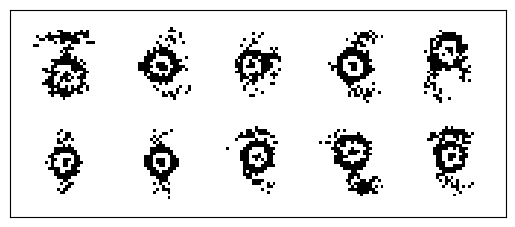

In [ ]:
def image_sampler(theta, pi, num_images):

    sample_class = np.random.choice(len(pi), size = num_images, p = pi)
    pixel_prob = theta[:, sample_class]
    sampled_images = np.random.binomial(1, pixel_prob)
    return np.transpose(sampled_images)


def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

If we assume that only 30% of the pixels are observed. For the first 30 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

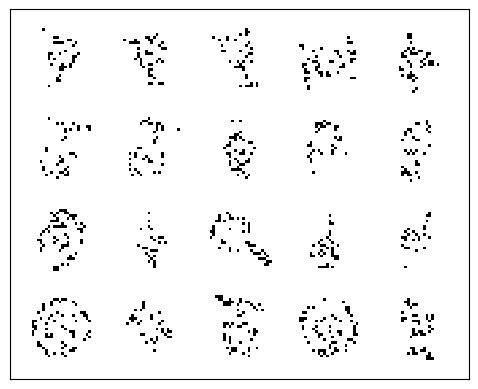

In [ ]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    N = original_images.shape[0]
    joint_log = np.empty((0,N))
    for c in range (len(pi)):
      log_theta = np.tile(np.log(theta[:,c]),(N,1))
      log_minus_theta = np.tile(np.log(1-theta[:,c]),(N,1))
      iteration = np.sum(log_theta * (original_images * is_observed) + \
      log_minus_theta * ((1-original_images) * is_observed), axis = 1) \
      + np.log(pi[c])
      joint_log = np.vstack((joint_log,iteration))
    log_like = joint_log - np.tile(np.log(np.sum(np.exp(joint_log), axis=0)),(len(pi), 1))
    prob = np.exp(log_like) # conditional probability
    label = np.array([np.random.choice(len(pi), 1, p=prob[:,i])[0] for i in range(N)])
    imputed_images = (1-is_observed) * np.transpose(theta[:,label]) + is_observed * original_images
    return imputed_images


num_features = train_images_binarized.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images_binarized[:20] * is_observed)

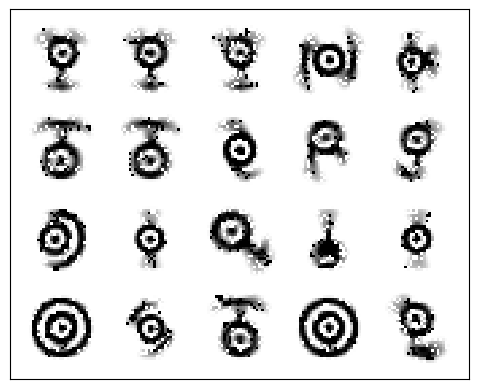

In [ ]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images_binarized[:20], is_observed)
plot_images(imputed_images)

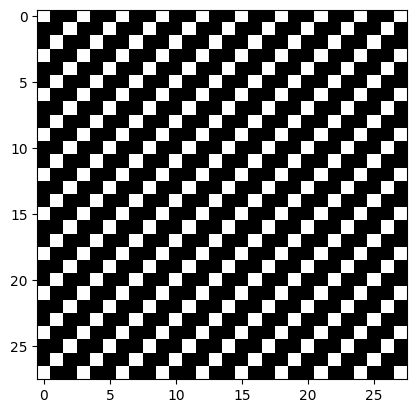

In [ ]:
h, w = 28, 28
p = 0.3

num_pixels = h * w
num_indices = int(num_pixels * p)

step_size = num_pixels // num_indices

indices = [(i // w, i % w) for i in range(0, num_pixels, step_size)]
flattened_indices = [row * w + col for row, col in indices]

one_hot_indices = np.zeros(num_pixels, dtype=int)
for index in flattened_indices:
    one_hot_indices[index] = 1

one_hot_matrix = one_hot_indices.reshape(h, w)

import matplotlib.pyplot as plt
plt.imshow(one_hot_matrix, cmap='gray')
plt.show()

Next we impute as before, except using this grid of observed indices.

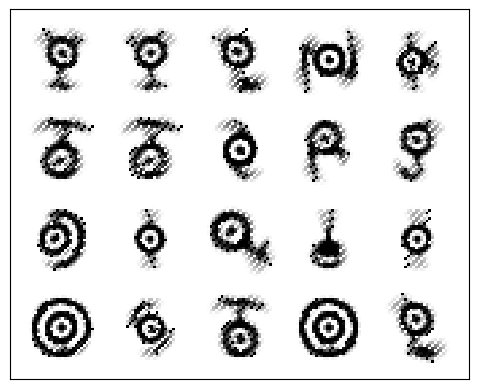

In [ ]:
repeated_one_hot_indices = np.tile(one_hot_indices, (20, 1))
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images_binarized[:20], repeated_one_hot_indices)
plot_images(imputed_images)

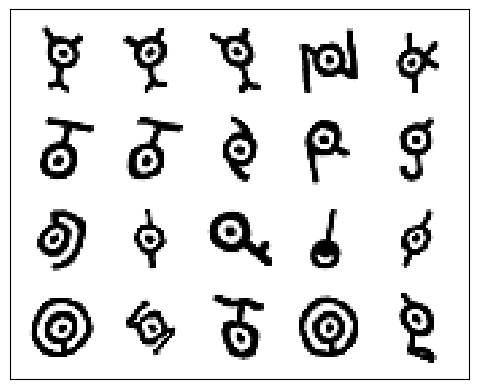

In [ ]:
plot_images(train_images[:20])

We now consider the Gaussian Naïve Bayes model, parameterized by $\mu$, $\Sigma$, $\pi$, to model the pixel data. Thus we revert back to representing each data sample using a continuous range of values, i.e. $x^{(i)} \in \mathbb{R}^{D}$, and we no longer use the binarized version of the data samples. (Note that in reality $x^{(i)} \in \left[0,1\right]^{D}$, but for the purposes of this question we will ignore this.) Here the joint probability distribution of $x$ and $c$ is given by $$p(x,c|\mu,\Sigma,\pi) =  p(c|\pi)p(x|c,\mu,\Sigma) = p(c|\pi)p(x|c,\mu,\Sigma),$$ where $p(x | c,\mu,\Sigma) = \frac{1}{\sqrt{\left(2\pi\right)^{D}|\Sigma_{c}|}}\exp\left(-\frac{1}{2}\left(x-\mu_{c}\right)^{T}\Sigma_{c}^{-1}\left(x-\mu_{c}\right)\right)$. As before $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

Maximum likelihood estimates of $\mu_{c}$, $\Sigma_{c},\pi_{c}$ for all $c \in \left\{1, \ldots, 10\right\}$.

Derivation: Say totally N observations: \
Likelihood function: $L(\mu,\Sigma,\pi|x^{(i)},c^{(i)})=\prod_{i=1}^{N}p(x^{(i)},c^{(i)}|\mu,\Sigma,\pi)=\prod_{i=1}^{N}p(c^{(i)}|\pi)p(x^{(i)}|c^{(i)},\mu,\Sigma)$ \
Log-likelihood: $l(\mu,\Sigma,\pi|x^{(i)},c^{(i)})=log\prod_{i=1}^{N}p(c^{(i)}|\pi)p(x^{(i)}|c^{(i)},\mu,\Sigma)$ \
$=\sum_{i=1}^{N}log \ p(c^{(i)}|\pi)+\sum_{i=1}^{N}log \ p(x^{(i)}|c^{(i)},\mu,\Sigma)$ \
$=\sum_{i=1}^{N}log \ \pi_{c^{(i)}}+\sum_{i=1}^{N}log\{\frac{1}{\sqrt{\left(2\pi\right)^{D}|\Sigma_{c^{(i)}}|}}\exp\left(-\frac{1}{2}\left(x^{(i)}-\mu_{c^{(i)}}\right)^{T}\Sigma_{c^{(i)}}^{-1}\left(x^{(i)}-\mu_{c^{(i)}}\right)\right)\}$ \
$=l_1(\pi)+l_2(\mu,\Sigma)$. \


*   Consider $l_1(\pi)$ to find MLE of $\pi_c$: \
Observe the formulation of $l_1(\pi)$ is the same as that in 2.1. So we should hava the same MLE here, which is: \
$\hat{\pi_c}=\frac{ ∑_{i=1}^{N}1\{c^{(i)}=c\}}{N}= \frac{number \ of \ c^{(i)} \ belong \ to \ class \ c}{total \ number \ of \ c^{(i)}}$, and the derivation steps should also be the same as in 2.1.
*   Consider $l_2(\mu,\Sigma)=\sum_{i=1}^{N}log\{\frac{1}{\sqrt{\left(2\pi\right)^{D}|\Sigma_{c^{(i)}}|}}\exp\left(-\frac{1}{2}\left(x^{(i)}-\mu_{c^{(i)}}\right)^{T}\Sigma_{c^{(i)}}^{-1}\left(x^{(i)}-\mu_{c^{(i)}}\right)\right)\}$ \
$=-\frac{D}{2}\sum_{i=1}^{N}log \ (2\pi)-\frac{1}{2}\sum_{i=1}^{N}log \ |\Sigma_{c^{(i)}}|-\frac{1}{2}\sum_{i=1}^{N}\left(x^{(i)}-\mu_{c^{(i)}}\right)^{T}\Sigma_{c^{(i)}}^{-1}\left(x^{(i)}-\mu_{c^{(i)}}\right)$. \
Take derivative wrt $\mu_c$ get its MLE: \
$\frac{∂l_2}{∂\mu_c}=-\frac{1}{2}\frac{∂}{∂\mu_c}\sum_{i=1}^{N}1\{c^{(i)}=c\}\left(x^{(i)}-\mu_{c^{(i)}}\right)^{T}\Sigma_{c^{(i)}}^{-1}\left(x^{(i)}-\mu_{c^{(i)}}\right)$ \
$=\sum_{i=1}^{N}1\{c^{(i)}=c\}\Sigma_{c^{(i)}}^{-1}(x^{(i)}-\mu_{c^{(i)}})=0$. \
Since $\Sigma_{c^{(i)}}^{-1}$ has full rank, we will have $\sum_{i=1}^{N}1\{c^{(i)}=c\}(x^{(i)}-\mu_{c^{(i)}})=0$, \
simplify to get $\hat{\mu_c}=\frac{\sum_{i=1}^{N}1\{c^{(i)}=c\}x^{(i)}}{\sum_{i=1}^{N}1\{c^{(i)}=c\}}$.
*   Take derivative wrt $\Sigma_c$ to get its MLE (we consider only terms containing $\Sigma_c$):
$\frac{∂l_2}{∂\Sigma_c}=\frac{∂}{∂\Sigma_c}\sum_{i=1}^N \mathbb{1}\{c^{(i)} = c\} \left(-\frac{1}{2} \log |\Sigma_{c^{(i)}}| - \frac{1}{2}(x^{(i)} - \mu_{c^{(i)}})^T \Sigma_{c^{(i)}}^{-1} (x^{(i)} - \mu_{c^{(i)}})\right)$ \
Use the fact that $\frac{∂}{∂\Sigma_c}log \ |\Sigma_c|=\Sigma_c^{-1}$, we will have: \
$\frac{∂l_2}{∂\Sigma_c}=-\frac{1}{2}\sum_{i=1}^{N}1\{c^{(i)}=c\} \Sigma_{c^{(i)}}^{-1} + \frac{1}{2} \sum_{i=1}^N \mathbb{1}\{c^{(i)} = c\} \Sigma_{c^{(i)}}^{-1}(x^{(i)} - \mu_{c^{(i)}})(x^{(i)} - \mu_{c^{(i)}})^T \Sigma_{c^{(i)}}^{-1} = 0$. \
Simplify to get $\hat{\Sigma_c} = \frac{\sum_{i: c^{(i)} = c} (x^{(i)} - \mu_{c^{(i)}})(x^{(i)} - \mu_{c^{(i)}})^T}{\sum_{i=1}^{N}1\{c^{(i)}=c\}}=\frac{\sum_{i: c^{(i)} = c} (x^{(i)} - \hat{\mu_c})(x^{(i)} - \hat{\mu_c})^T}{\sum_{i=1}^{N}1\{c^{(i)}=c\}}$ such that $\hat{\mu_c}$ is the MLE of $\mu_c$.


In [ ]:
def train_gnb_mle_estimator(train_images, train_labels, epsilon=1e-6):
    """ Inputs:
        train_images (N_samples x N_features)
        train_labels (N_samples x N_classes)
        Returns the MLE estimators mu_est, sigma_est, pi_est.
    """
    # pi_est
    pi_est = np.mean(train_labels, axis = 0)
    # mu_est
    mu_est = np.dot(np.transpose(train_labels),train_images) / \
    np.sum(train_labels, axis = 0)[:, np.newaxis]
    # sigma_est
    N = train_labels.shape[0]
    C = train_labels.shape[1]
    D = train_images.shape[1]
    sigma_est = np.zeros((C,D,D))
    for c in range(C):
      x_c = train_images[train_labels[:,c] == 1]
      numerator = (x_c - mu_est[c]) ** 2
      cov = np.sum(numerator, axis = 0) / np.sum(train_labels, axis = 0)[c] + epsilon
      sigma_est[c, :, :] = np.diag(cov)
    return mu_est, sigma_est, pi_est

Class log-likelihood $\log p(c|x,\mu,\Sigma,\pi)$ for a single image.


Derivation: \
Bayes Theorem says: $P(c|x, \mu,\Sigma, \pi) = \frac{P(c,x| \mu,\Sigma, \pi)}{P(x|\mu,\Sigma,\pi)}$. \
Since we know $p(x,c|\mu,\Sigma,\pi) = p(c|\pi)p(x|c,\mu,\Sigma) =\frac{\pi_c}{\sqrt{\left(2\pi\right)^{D}|\Sigma_{c}|}}\exp\left(-\frac{1}{2}\left(x-\mu_{c}\right)^{T}\Sigma_{c}^{-1}\left(x-\mu_{c}\right)\right)$ for some class $c$, \
then take natural log to get $log \ p(c,x|\mu,\Sigma,\pi)=log(\pi_c)-\frac{D}{2}log(2\pi)-\frac{1}{2}log \ |\Sigma_c|-\frac{1}{2}(x-\mu_c)^T\Sigma_c^{-1}(x-\mu_c)$. \
Now consider denominator, it's obvious that $p(x|\mu,\Sigma,\pi)=\sum_{c \in [28]}p(x,c|\mu,\Sigma,\pi)$, \
so we would have $p(x|\mu,\Sigma,\pi)=\sum_{c \in [28]}exp\{log \ p(c,x|\mu,\Sigma,\pi)\}$, \
thus implying $log \ p(c|x, \mu,\Sigma, \pi)=log \ p(c,x| \mu,\Sigma, \pi)-\sum_{c \in [28]}exp\{log \ p(c,x|\mu,\Sigma,\pi)\}$, \
with the expansion of conditional joint distribution shown above.

In [ ]:
def gnb_log_likelihood(images, mu, sigma, pi, epsilon):
    sigma = sigma + epsilon

    N = images.shape[0]
    C = len(pi)
    D = images.shape[1]
    joint_log = np.zeros((N,C))
    for c in range(C):
      sigma_inv = 1 / np.diag(sigma[c])
      func_1 = np.log(pi[c])
      func_2 = - D * np.log(2 * np.pi)/ 2
      func_3 = - 1 * np.sum(np.log(np.diag(sigma[c]))) / 2
      func_4 = - np.sum((images - mu[c]) ** 2 * sigma_inv, axis = 1) / 2
      joint_log[:,c] += func_1 + func_2 + func_3 + func_4
    log_like = joint_log # we can ignore normalization here
    return log_like


N_data, train_images, _, train_labels, test_images, _, test_labels = load_unown_mnist()
mu_est, sigma_est, pi_est = train_gnb_mle_estimator(train_images, train_labels)

epsilon = 1e-05
loglike_train = gnb_log_likelihood(train_images, mu_est, sigma_est, pi_est, epsilon)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = gnb_log_likelihood(test_images, mu_est, sigma_est, pi_est, epsilon)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MLE (with variance smoothing) is {avg_loglike:.3f}")
print(f"Training accuracy for MLE (with variance smoothing) is {train_accuracy:.3f}")
print(f"Test accuracy for MLE (with variance smoothing) is {test_accuracy:.3f}")

Average log-likelihood for MLE (with variance smoothing) is 1803.901
Training accuracy for MLE (with variance smoothing) is 0.998
Test accuracy for MLE (with variance smoothing) is 0.995
